# Embedding texts that are longer than the model's maximum context length

OpenAI's embedding models cannot embed text that exceeds a maximum length. The maximum length varies by model, and is measured by _tokens_, not string length. If you are unfamiliar with tokenization, check out [How to count tokens with tiktoken](How_to_count_tokens_with_tiktoken.ipynb).

This notebook shows how to handle texts that are longer than a model's maximum context length. We'll demonstrate using embeddings from `text-embedding-3-small`, but the same ideas can be applied to other models and tasks. To learn more about embeddings, check out the [OpenAI Embeddings Guide](https://beta.openai.com/docs/guides/embeddings).


## 1. Model context length

First, we select the model and define a function to get embeddings from the API.

In [1]:
from openai import AzureOpenAI
import os
import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt, retry_if_not_exception_type

from dotenv import load_dotenv
load_dotenv()

client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
  api_key=os.getenv("AZURE_OPENAI_KEY"),  
  api_version="2024-02-15-preview"
)

EMBEDDING_MODEL = 'text-embedding-ada-002'
EMBEDDING_CTX_LENGTH = 8191
EMBEDDING_ENCODING = 'cl100k_base'

# let's make sure to not retry on an invalid request, because that is what we want to demonstrate
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6), retry=retry_if_not_exception_type(openai.BadRequestError))
def get_embedding(text_or_tokens, model=EMBEDDING_MODEL):
    return client.embeddings.create(input=text_or_tokens, model=model).data[0].embedding

The `text-embedding-3-small` model has a context length of 8191 tokens with the `cl100k_base` encoding, and we can see that going over that limit causes an error.

In [2]:
long_text = 'AGI ' * 5000
try:
    get_embedding(long_text)
except openai.BadRequestError as e:
    print(e)

Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 10001 tokens (10001 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Clearly we want to avoid these errors, particularly when handling programmatically with a large number of embeddings. Yet, we still might be faced with texts that are longer than the maximum context length. Below we describe and provide recipes for the main approaches to handling these longer texts: (1) simply truncating the text to the maximum allowed length, and (2) chunking the text and embedding each chunk individually.

## 1. Truncating the input text

The simplest solution is to truncate the input text to the maximum allowed length. Because the context length is measured in tokens, we have to first tokenize the text before truncating it. The API accepts inputs both in the form of text or tokens, so as long as you are careful that you are using the appropriate encoding, there is no need to convert the tokens back into string form. Below is an example of such a truncation function.

In [3]:
import tiktoken

def truncate_text_tokens(text, encoding_name=EMBEDDING_ENCODING, max_tokens=EMBEDDING_CTX_LENGTH):
    """Truncate a string to have `max_tokens` according to the given encoding."""
    encoding = tiktoken.get_encoding(encoding_name)
    return encoding.encode(text)[:max_tokens]

Our example from before now works without error.

In [4]:
truncated = truncate_text_tokens(long_text)
len(get_embedding(truncated))

1536

## 2. Chunking the input text

Though truncation works, discarding potentially relevant text is a clear drawback. Another approach is to divide the input text into chunks and then embed each chunk individually. Then, we can either use the chunk embeddings separately, or combine them in some way, such as averaging (weighted by the size of each chunk).

We will take a function from [Python's own cookbook](https://docs.python.org/3/library/itertools.html#itertools-recipes) that breaks up a sequence into chunks.

In [5]:
from itertools import islice

def batched(iterable, n):
    """Batch data into tuples of length n. The last batch may be shorter."""
    # batched('ABCDEFG', 3) --> ABC DEF G
    if n < 1:
        raise ValueError('n must be at least one')
    it = iter(iterable)
    while (batch := tuple(islice(it, n))):
        yield batch

Now we define a function that encodes a string into tokens and then breaks it up into chunks.

In [6]:
def chunked_tokens(text, encoding_name, chunk_length):
    encoding = tiktoken.get_encoding(encoding_name)
    tokens = encoding.encode(text)
    chunks_iterator = batched(tokens, chunk_length)
    yield from chunks_iterator

Finally, we can write a function that safely handles embedding requests, even when the input text is longer than the maximum context length, by chunking the input tokens and embedding each chunk individually. The `average` flag can be set to `True` to return the weighted average of the chunk embeddings, or `False` to simply return the unmodified list of chunk embeddings.

In [7]:
import numpy as np


def len_safe_get_embedding(text, model=EMBEDDING_MODEL, max_tokens=EMBEDDING_CTX_LENGTH, encoding_name=EMBEDDING_ENCODING, average=True):
    chunk_embeddings = []
    chunk_lens = []
    for chunk in chunked_tokens(text, encoding_name=encoding_name, chunk_length=max_tokens):
        chunk_embeddings.append(get_embedding(chunk, model=model))
        chunk_lens.append(len(chunk))

    if average:
        chunk_embeddings = np.average(chunk_embeddings, axis=0, weights=chunk_lens)
        chunk_embeddings = chunk_embeddings / np.linalg.norm(chunk_embeddings)  # normalizes length to 1
        chunk_embeddings = chunk_embeddings.tolist()
    return chunk_embeddings

Once again, we can now handle long input texts.

In [8]:
average_embedding_vector = len_safe_get_embedding(long_text, average=True)
chunks_embedding_vectors = len_safe_get_embedding(long_text, average=False)

print(f"Setting average=True gives us a single {len(average_embedding_vector)}-dimensional embedding vector for our long text.")
print(f"Setting average=False gives us {len(chunks_embedding_vectors)} embedding vectors, one for each of the chunks.")


Setting average=True gives us a single 1536-dimensional embedding vector for our long text.
Setting average=False gives us 2 embedding vectors, one for each of the chunks.


In some cases, it may make sense to split chunks on paragraph boundaries or sentence boundaries to help preserve the meaning of the text.

# Ejercicio 1: Visualización de la Distribución de Tokens
# Visualizar la distribución de tokens para diferentes textos largos


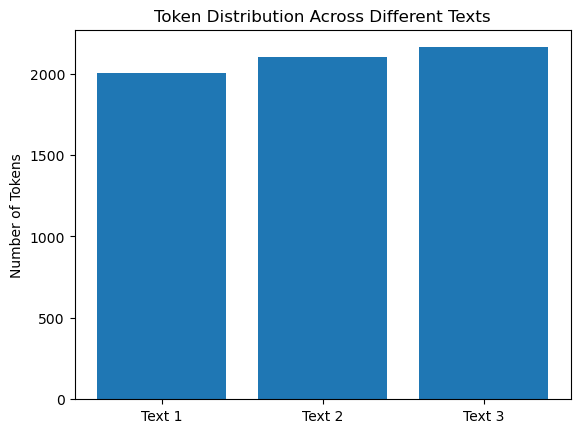

In [18]:
import matplotlib.pyplot as plt
import tiktoken

texts = [
    "Lorem ipsum dolor sit amet, consectetur adipiscing elit. " * 200,
    "Data science is evolving rapidly with the use of machine learning and AI. " * 150,
    "Azure OpenAI embeddings provide powerful tools for natural language processing. " * 180
]

encoding = tiktoken.get_encoding(EMBEDDING_ENCODING) #FIXME
text_tokens = [encoding.encode(text) for text in texts]
token_lengths = [len(tokens) for tokens in text_tokens]

plt.bar(["Text 1", "Text 2", "Text 3"], token_lengths)
plt.ylabel("Number of Tokens")
plt.title("Token Distribution Across Different Texts")
plt.show()

# Ejercicio 2: Análisis de la Pérdida de Información con Truncado
# Comparar embeddings con texto completo vs truncado y calcular la similitud coseno


In [20]:
from sklearn.metrics.pairwise import cosine_similarity

text = "Natural language processing models are essential for AI applications. " * 300
truncated_tokens = truncate_text_tokens(text)

full_embedding = get_embedding(text) #FIXME
truncated_embedding = get_embedding(truncated_tokens) #FIXME

similarity = cosine_similarity([full_embedding], [truncated_embedding])[0][0]
print(f"Cosine Similarity between full and truncated embeddings: {similarity:.4f}")


Cosine Similarity between full and truncated embeddings: 1.0000


# Ejercicio 3: Chunking Basado en Límites de Párrafos
# Implementar una función que divida el texto por párrafos y embeba cada párrafo por separado


In [21]:
def paragraph_chunker(text, max_tokens=EMBEDDING_CTX_LENGTH):
    paragraphs = text.split("\n\n")
    embeddings = []
    for paragraph in paragraphs:
        tokens = encoding.encode(paragraph)
        if len(tokens) > max_tokens:
            truncated = truncate_text_tokens(paragraph)
            embeddings.append(get_embedding(truncated))
        else:
            embeddings.append(get_embedding(tokens))
    return embeddings

paragraph_text = """
Azure AI services are expanding rapidly.\n\n
These services include natural language processing and computer vision.\n\n
Embedding models allow for advanced text analytics.\n\n
With Azure, developers can scale their applications easily.
"""

paragraph_embeddings = paragraph_chunker(paragraph_text)
print(f"Generated {len(paragraph_embeddings)} embeddings, one for each paragraph.")

Generated 4 embeddings, one for each paragraph.


# Ejercicio 4: Fusionar Embeddings de Chunks con Diferentes Estrategias
# Comparar promedios simples vs ponderados por longitud del chunk


In [22]:
def merge_embeddings(embeddings, strategy="weighted"):
    if strategy == "weighted":
        weights = [len(embedding) for embedding in embeddings]
        merged = np.average(embeddings, axis=0, weights=weights)
    elif strategy == "simple":
        merged = np.mean(embeddings, axis=0)
    else:
        raise ValueError("Invalid strategy. Choose 'weighted' or 'simple'.")
    return merged / np.linalg.norm(merged)

merged_weighted = merge_embeddings(paragraph_embeddings, strategy="weighted")
merged_simple = merge_embeddings(paragraph_embeddings, strategy="simple") #FIXME

similarity = cosine_similarity([merged_weighted], [merged_simple])[0][0]
print(f"Cosine Similarity between weighted and simple average embeddings: {similarity:.4f}")


Cosine Similarity between weighted and simple average embeddings: 1.0000
